In [2]:
!pip install torch


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 44.0 MB/s eta 0:00:0000:0100:01


In [1]:
import os
import glob
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
from tqdm.auto import tqdm

In [2]:
import zipfile, os, pathlib

zip_path = "results.zip"       
extract_root = pathlib.Path("data_raw")
extract_root.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_root)

print("Extracted files under:", extract_root)
print(os.listdir(extract_root))  


Extracted files under: data_raw
['results', '__MACOSX']


In [3]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 128     # keep 64 for now
BATCH_SIZE = 8
NUM_WORKERS = 2

DATA_FOLDER = "data_raw/results"


In [4]:
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class ReadingImages(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = []
        for ext in ("*.png", "*.jpg", "*.jpeg", "*.webp"):
            self.paths.extend(glob.glob(os.path.join(folder, "**", ext), recursive=True))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),   # [0,1] -> [-1,1]
])

dataset = ReadingImages(DATA_FOLDER, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS, drop_last=True)

print("Loaded", len(dataset), "images.")


Loaded 21551 images.


/vol/home/s4417712/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


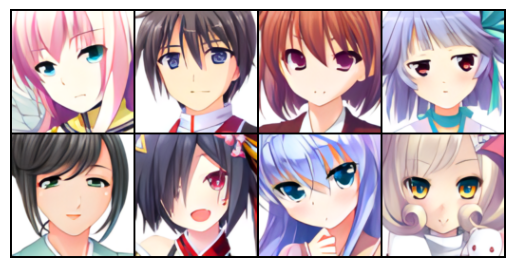

In [5]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

batch = next(iter(loader))
grid = make_grid(batch[:16] * 0.5 + 0.5, nrow=4)
plt.imshow(grid.permute(1,2,0))
plt.axis("off");


In [6]:
import math
import torch.nn as nn
import torch.nn.functional as F

DIFFUSION_STEPS = 1000

betas = torch.linspace(1e-4, 0.02, DIFFUSION_STEPS, device=DEVICE)
alphas = 1.0 - betas
cum_alpha_bar = torch.cumprod(alphas, dim=0)
alpha_bar_prev = torch.cat([torch.tensor([1.0], device=DEVICE), cum_alpha_bar[:-1]])

class SinCosPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.post_mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.SiLU(),
            nn.Linear(dim * 2, dim)
        )

    def forward(self, t):
        half = self.dim // 2
        t = t.float() / float(DIFFUSION_STEPS)
        freqs = torch.exp(-math.log(20000) * torch.arange(half, device=t.device).float() / half)
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros(t.size(0), 1, device=t.device)], dim=-1)
        return self.post_mlp(emb)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = F.relu(h)
        h = self.conv2(h)
        return h + self.shortcut(x)

class Downsample(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(c_in, c_out, 4, 2, 1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.model(x)

class Upsample(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, 4, 2, 1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.model(x)

class UNetMedium(nn.Module):
    def __init__(self, img_channels=3, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_embedding = SinCosPosEmb(time_emb_dim)

        # encoder
        self.c1 = ResidualBlock(img_channels,      base_channels,     time_emb_dim)  # 128
        self.d1 = Downsample(base_channels,        base_channels * 2)                # 64
        self.c2 = ResidualBlock(base_channels * 2, base_channels * 2, time_emb_dim)
        self.d2 = Downsample(base_channels * 2,    base_channels * 4)                # 32
        self.c3 = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)
        self.d3 = Downsample(base_channels * 4,    base_channels * 8)                # 16
        self.c4 = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim)  # bottleneck

        # decoder
        self.u1 = Upsample(base_channels * 8,      base_channels * 4)                # 16 -> 32
        self.c5 = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)
        self.u2 = Upsample(base_channels * 4,      base_channels * 2)                # 32 -> 64
        self.c6 = ResidualBlock(base_channels * 2, base_channels * 2, time_emb_dim)
        self.u3 = Upsample(base_channels * 2,      base_channels)                    # 64 -> 128
        self.c7 = ResidualBlock(base_channels,     base_channels,     time_emb_dim)

        self.final = nn.Conv2d(base_channels, img_channels, 1)

    def forward(self, x, t):
        if t.ndim > 1:
            t = t.view(-1)
        t_emb = self.time_embedding(t)

        x1 = self.c1(x, t_emb)
        x2 = self.c2(self.d1(x1), t_emb)
        x3 = self.c3(self.d2(x2), t_emb)
        x4 = self.c4(self.d3(x3), t_emb)

        u1 = self.c5(self.u1(x4), t_emb)
        u2 = self.c6(self.u2(u1), t_emb)
        u3 = self.c7(self.u3(u2), t_emb)

        return self.final(u3)




In [7]:
def sample_timesteps(n):
    return torch.randint(low=0, high=DIFFUSION_STEPS, size=(n,), device=DEVICE)

model = UNetMedium().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mse = nn.MSELoss()

EPOCHS = 100    
print("Starting diffusion training on", DEVICE)

for epoch in range(EPOCHS):
    for batch in loader:
        batch = batch.to(DEVICE)
        t = sample_timesteps(batch.size(0))
        noise = torch.randn_like(batch)

        alpha_bar_t = cum_alpha_bar[t].view(-1,1,1,1)
        noisy = torch.sqrt(alpha_bar_t) * batch + torch.sqrt(1.0 - alpha_bar_t) * noise

        noise_pred = model(noisy, t)
        loss = mse(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss.item():.4f}")


Starting diffusion training on cuda
Epoch 1/100 - Loss: 0.3472
Epoch 2/100 - Loss: 0.3541
Epoch 3/100 - Loss: 0.2000
Epoch 4/100 - Loss: 0.0757
Epoch 5/100 - Loss: 0.0470
Epoch 6/100 - Loss: 0.0845
Epoch 7/100 - Loss: 0.0146
Epoch 8/100 - Loss: 0.0169
Epoch 9/100 - Loss: 0.0165
Epoch 10/100 - Loss: 0.0147
Epoch 11/100 - Loss: 0.0109
Epoch 12/100 - Loss: 0.0163
Epoch 13/100 - Loss: 0.0337
Epoch 14/100 - Loss: 0.0159
Epoch 15/100 - Loss: 0.0229
Epoch 16/100 - Loss: 0.0125
Epoch 17/100 - Loss: 0.0358
Epoch 18/100 - Loss: 0.0593
Epoch 19/100 - Loss: 0.0301
Epoch 20/100 - Loss: 0.0315
Epoch 21/100 - Loss: 0.0185
Epoch 22/100 - Loss: 0.0111
Epoch 23/100 - Loss: 0.0175
Epoch 24/100 - Loss: 0.0182
Epoch 25/100 - Loss: 0.0582
Epoch 26/100 - Loss: 0.0145
Epoch 27/100 - Loss: 0.0058
Epoch 28/100 - Loss: 0.0559
Epoch 29/100 - Loss: 0.0232
Epoch 30/100 - Loss: 0.0119
Epoch 31/100 - Loss: 0.0576
Epoch 32/100 - Loss: 0.0543
Epoch 33/100 - Loss: 0.0139
Epoch 34/100 - Loss: 0.0112
Epoch 35/100 - Loss: 

In [8]:
import torchvision.utils as vutils

@torch.no_grad()
def sample_ddpm(model, n=16):
    model.eval()
    x = torch.randn(n, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)

    for t in reversed(range(DIFFUSION_STEPS)):
        t_batch = torch.full((n,), t, device=DEVICE, dtype=torch.long)
        eps_theta = model(x, t_batch)

        alpha_t = alphas[t]
        alpha_bar_t = cum_alpha_bar[t]
        beta_t = betas[t]

        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mean = coef1 * (x - coef2 * eps_theta)

        if t > 0:
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_t) * noise
        else:
            x = mean

    x = (x.clamp(-1,1) + 1) * 0.5
    return x

# generate and show
samples = sample_ddpm(model, n=16)
vutils.save_image(samples, "diffusion_outputs.png", nrow=4)


In [9]:
import torch.nn as nn

# 128x128 Generator
class WGANGen128(nn.Module):
    def __init__(self, z_dim=128, gf=64, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            # z: (z_dim, 1, 1) -> (gf*16, 4, 4)
            nn.ConvTranspose2d(z_dim, gf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gf * 16),
            nn.ReLU(True),

            # 4 -> 8
            nn.ConvTranspose2d(gf * 16, gf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf * 8),
            nn.ReLU(True),

            # 8 -> 16
            nn.ConvTranspose2d(gf * 8, gf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf * 4),
            nn.ReLU(True),

            # 16 -> 32
            nn.ConvTranspose2d(gf * 4, gf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf * 2),
            nn.ReLU(True),

            # 32 -> 64
            nn.ConvTranspose2d(gf * 2, gf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf),
            nn.ReLU(True),

            # 64 -> 128
            nn.ConvTranspose2d(gf, img_channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)



class WGANCritic128(nn.Module):
    def __init__(self, df=64, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            # 128 -> 64
            nn.Conv2d(img_channels, df, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 -> 32
            nn.Conv2d(df, df * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(df * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # 32 -> 16
            nn.Conv2d(df * 2, df * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(df * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # 16 -> 8
            nn.Conv2d(df * 4, df * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(df * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # 8 -> 4
            nn.Conv2d(df * 8, df * 16, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(df * 16, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # 4 -> 1
            nn.Conv2d(df * 16, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [10]:
def gradient_penalty(critic, real, fake, device):
    bsz = real.size(0)
    eps = torch.rand(bsz, 1, 1, 1, device=device)
    interpolated = eps * real + (1 - eps) * fake
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated)
    grad_outputs = torch.ones_like(mixed_scores, device=device)

    gradients = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(bsz, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


In [36]:
z_dim = 128
lr = 1e-4
critic_iters = 5
lambda_gp = 10
epochs_gan = 20

G = WGANGen128(z_dim=z_dim).to(DEVICE)
C = WGANCritic128().to(DEVICE)

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.0, 0.9))
fixed_noise = torch.randn(64, z_dim, 1, 1, device=DEVICE)


print("Starting WGAN-GP training...")
for epoch in range(epochs_gan):
    for real in loader:
        real = real.to(DEVICE)
        bsz = real.size(0)

        # --- Train critic multiple times ---
        for _ in range(critic_iters):
            noise = torch.randn(bsz, z_dim, 1, 1, device=DEVICE)
            fake = G(noise)

            real_score = C(real)
            fake_score = C(fake.detach())
            gp = gradient_penalty(C, real, fake, DEVICE)

            loss_C = -(real_score.mean() - fake_score.mean()) + lambda_gp * gp

            opt_C.zero_grad()
            loss_C.backward()
            opt_C.step()

        # --- Train generator ---
        fake = G(noise)
        fake_score = C(fake)
        loss_G = -fake_score.mean()

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs_gan} | Critic: {loss_C.item():.4f} | Gen: {loss_G.item():.4f}")

    with torch.no_grad():
        fake_samples = G(fixed_noise).cpu() * 0.5 + 0.5
    vutils.save_image(fake_samples, f"WGAN_GP_epoch_{epoch+1:03d}.png", nrow=8)


Starting WGAN-GP training...
Epoch 1/20 | Critic: -60.9778 | Gen: 102.6184
Epoch 2/20 | Critic: -53.0901 | Gen: 152.4764
Epoch 3/20 | Critic: -43.7208 | Gen: 164.0235
Epoch 4/20 | Critic: -67.1864 | Gen: 149.3754
Epoch 5/20 | Critic: -77.8923 | Gen: 157.4391
Epoch 6/20 | Critic: -62.7682 | Gen: 189.6729
Epoch 7/20 | Critic: -43.8456 | Gen: 204.1317
Epoch 8/20 | Critic: -40.7019 | Gen: 224.9590
Epoch 9/20 | Critic: -53.4262 | Gen: 197.0083
Epoch 10/20 | Critic: -50.8514 | Gen: 200.8610
Epoch 11/20 | Critic: -43.5437 | Gen: 235.3773
Epoch 12/20 | Critic: -59.4249 | Gen: 231.8249
Epoch 13/20 | Critic: -56.8245 | Gen: 223.7701
Epoch 14/20 | Critic: -61.5292 | Gen: 217.3757
Epoch 15/20 | Critic: -49.0244 | Gen: 200.1030
Epoch 16/20 | Critic: -66.7874 | Gen: 196.6583
Epoch 17/20 | Critic: -45.9834 | Gen: 205.9741
Epoch 18/20 | Critic: -43.4388 | Gen: 206.4247
Epoch 19/20 | Critic: -70.2048 | Gen: 191.9424
Epoch 20/20 | Critic: -55.7582 | Gen: 205.6132


In [11]:
z_dim = 128
lr = 1e-4
critic_iters = 5
lambda_gp = 10
epochs_gan = 100

G = WGANGen128(z_dim=z_dim).to(DEVICE)
C = WGANCritic128().to(DEVICE)

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.0, 0.9))
fixed_noise = torch.randn(64, z_dim, 1, 1, device=DEVICE)


print("Starting WGAN-GP training...")
for epoch in range(epochs_gan):
    for real in loader:
        real = real.to(DEVICE)
        bsz = real.size(0)

        # --- Train critic multiple times ---
        for _ in range(critic_iters):
            noise = torch.randn(bsz, z_dim, 1, 1, device=DEVICE)
            fake = G(noise)

            real_score = C(real)
            fake_score = C(fake.detach())
            gp = gradient_penalty(C, real, fake, DEVICE)

            loss_C = -(real_score.mean() - fake_score.mean()) + lambda_gp * gp

            opt_C.zero_grad()
            loss_C.backward()
            opt_C.step()

        # --- Train generator ---
        fake = G(noise)
        fake_score = C(fake)
        loss_G = -fake_score.mean()

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs_gan} | Critic: {loss_C.item():.4f} | Gen: {loss_G.item():.4f}")

    with torch.no_grad():
        fake_samples = G(fixed_noise).cpu() * 0.5 + 0.5
    vutils.save_image(fake_samples, f"WGAN_GP_updatedepoch_{epoch+1:03d}.png", nrow=8)


Starting WGAN-GP training...
Epoch 1/100 | Critic: -73.2028 | Gen: 114.0270
Epoch 2/100 | Critic: -58.1966 | Gen: 120.4566
Epoch 3/100 | Critic: -79.7212 | Gen: 203.6643
Epoch 4/100 | Critic: -60.9299 | Gen: 188.5938
Epoch 5/100 | Critic: -67.2271 | Gen: 194.3770
Epoch 6/100 | Critic: -43.7630 | Gen: 205.5508
Epoch 7/100 | Critic: -58.1016 | Gen: 237.9692
Epoch 8/100 | Critic: -49.2527 | Gen: 192.8439
Epoch 9/100 | Critic: -68.7918 | Gen: 230.1631
Epoch 10/100 | Critic: -44.6394 | Gen: 222.3843
Epoch 11/100 | Critic: -52.7329 | Gen: 244.8324
Epoch 12/100 | Critic: -50.4074 | Gen: 222.9509
Epoch 13/100 | Critic: -53.3535 | Gen: 226.2944
Epoch 14/100 | Critic: -65.7247 | Gen: 198.6442
Epoch 15/100 | Critic: -53.1377 | Gen: 205.2935
Epoch 16/100 | Critic: -65.7599 | Gen: 162.8198
Epoch 17/100 | Critic: -37.9022 | Gen: 214.6567
Epoch 18/100 | Critic: -43.4944 | Gen: 170.6729
Epoch 19/100 | Critic: -72.3269 | Gen: 214.1362
Epoch 20/100 | Critic: -61.6689 | Gen: 197.2132
Epoch 21/100 | Criti

Starting WGAN-GP experiments...

 Training WGAN-GP with lr = 0.0001

[lr=0.0001] Epoch 1/100 | Critic: -59.2328 | Gen: 98.3243
[lr=0.0001] Epoch 2/100 | Critic: -61.0912 | Gen: 123.8314
[lr=0.0001] Epoch 3/100 | Critic: -52.4390 | Gen: 100.4574
[lr=0.0001] Epoch 4/100 | Critic: -48.6406 | Gen: 133.2342
[lr=0.0001] Epoch 5/100 | Critic: -37.5436 | Gen: 191.1378
[lr=0.0001] Epoch 6/100 | Critic: -68.0647 | Gen: 194.9218
[lr=0.0001] Epoch 7/100 | Critic: -52.6818 | Gen: 171.7016
[lr=0.0001] Epoch 8/100 | Critic: -44.2054 | Gen: 246.3100
[lr=0.0001] Epoch 9/100 | Critic: -53.4422 | Gen: 204.5500
[lr=0.0001] Epoch 10/100 | Critic: -71.1066 | Gen: 248.9887
[lr=0.0001] Epoch 11/100 | Critic: -48.6514 | Gen: 267.2024
[lr=0.0001] Epoch 12/100 | Critic: -46.3655 | Gen: 216.4008
[lr=0.0001] Epoch 13/100 | Critic: -54.8048 | Gen: 246.9498
[lr=0.0001] Epoch 14/100 | Critic: -63.5019 | Gen: 223.3427
[lr=0.0001] Epoch 15/100 | Critic: -60.7249 | Gen: 209.9851
[lr=0.0001] Epoch 16/100 | Critic: -34.66

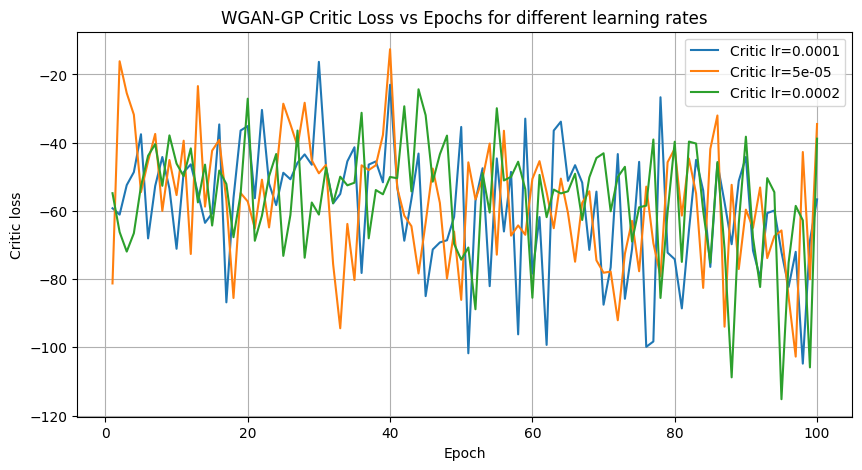

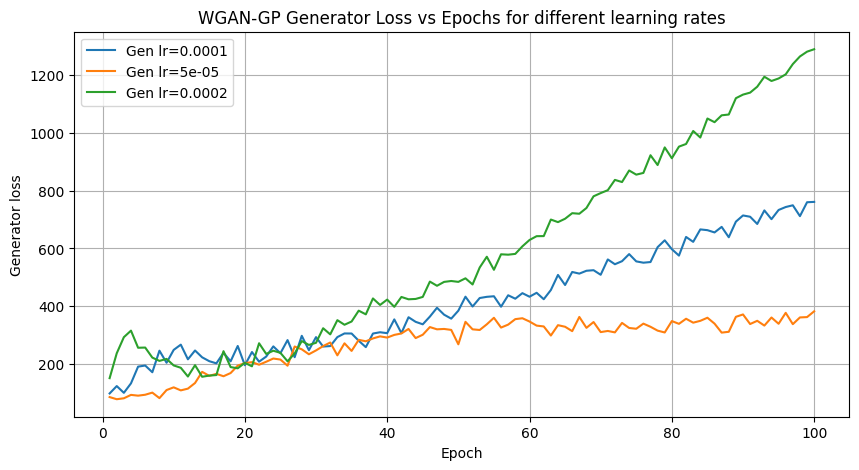

In [12]:
import os
import matplotlib.pyplot as plt

# ------------ hyperparams -------------
z_dim = 128
critic_iters = 5
lambda_gp = 10
epochs_gan = 100

# try different learning rates
learning_rates = [1e-4, 5e-5, 2e-4]   # you can add/remove values here

# to store loss curves for visualization
history_G = {}
history_C = {}

print("Starting WGAN-GP experiments...")

for lr in learning_rates:
    print("\n====================================")
    print(f" Training WGAN-GP with lr = {lr}")
    print("====================================\n")

    # output folder for this lr
    out_dir = f"WGAN_GP_lr_{lr}"
    os.makedirs(out_dir, exist_ok=True)

    # ---- init models & optimizers ----
    G = WGANGen128(z_dim=z_dim).to(DEVICE)
    C = WGANCritic128().to(DEVICE)

    opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
    opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.0, 0.9))

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=DEVICE)

    # loss history for this lr
    gen_losses = []
    critic_losses = []

    for epoch in range(epochs_gan):
        for real in loader:
            real = real.to(DEVICE)
            bsz = real.size(0)

            # --- Train critic multiple times ---
            for _ in range(critic_iters):
                noise = torch.randn(bsz, z_dim, 1, 1, device=DEVICE)
                fake = G(noise)

                real_score = C(real)
                fake_score = C(fake.detach())
                gp = gradient_penalty(C, real, fake, DEVICE)

                loss_C = -(real_score.mean() - fake_score.mean()) + lambda_gp * gp

                opt_C.zero_grad()
                loss_C.backward()
                opt_C.step()

            # --- Train generator ---
            noise = torch.randn(bsz, z_dim, 1, 1, device=DEVICE)
            fake = G(noise)
            fake_score = C(fake)
            loss_G = -fake_score.mean()

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        # store epoch losses
        critic_losses.append(loss_C.item())
        gen_losses.append(loss_G.item())

        print(f"[lr={lr}] Epoch {epoch+1}/{epochs_gan} | "
              f"Critic: {loss_C.item():.4f} | Gen: {loss_G.item():.4f}")

        # save sample grid every 10 epochs
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                fake_samples = G(fixed_noise).cpu() * 0.5 + 0.5
            vutils.save_image(
                fake_samples,
                os.path.join(out_dir, f"epoch_{epoch+1:03d}.png"),
                nrow=8
            )

    # store histories for this lr
    history_C[lr] = critic_losses
    history_G[lr] = gen_losses

# ------------ visualizing loss curves ------------

epochs = range(1, epochs_gan + 1)

plt.figure(figsize=(10, 5))
for lr, losses in history_C.items():
    plt.plot(epochs, losses, label=f"Critic lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Critic loss")
plt.title("WGAN-GP Critic Loss vs Epochs for different learning rates")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for lr, losses in history_G.items():
    plt.plot(epochs, losses, label=f"Gen lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Generator loss")
plt.title("WGAN-GP Generator Loss vs Epochs for different learning rates")
plt.legend()
plt.grid(True)
plt.show()
